# **Estudiantes:**
- Fabian Tovar
- Felipe García
- Jesús Figueroba

# Funciones

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# -----------------------------------------------------
# 1.1 Descarga y preprocesamiento
# -----------------------------------------------------

def download_data(tickers, start, end):
    """
    Descarga precios ajustados de cierre de activos.
    """
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)["Adj Close"]
    if isinstance(data, pd.Series):  # si es solo un ticker
        data = data.to_frame()
    return data.dropna(how="all")

def preprocess_data(tickers, rf_ticker, start, end):
    """
    Descarga activos + tasa libre de riesgo (^IRX),
    alinea calendarios y elimina faltantes.
    """
    prices_assets = download_data(tickers, start, end)
    prices_rf = download_data(rf_ticker, start, end)
    data_all = prices_assets.join(prices_rf, how="inner").dropna()
    return data_all

# -----------------------------------------------------
# 1.2 Conversión de tasa libre de riesgo
# -----------------------------------------------------

def convert_rf(data_rf: pd.DataFrame):
    """
    Convierte ^IRX (tasa anualizada %) a:
    - tasa anual en decimales
    - tasa diaria efectiva
    """
    rf_ann = data_rf / 100  # convertir de % a proporción
    rf_daily = (1 + rf_ann) ** (1/252) - 1
    rf_ann.columns = [c + "_ann" for c in rf_ann.columns]
    rf_daily.columns = [c + "_daily" for c in rf_daily.columns]
    return rf_ann, rf_daily

# -----------------------------------------------------
# 1.3 Exceso de retorno y exposición
# -----------------------------------------------------

def compute_returns(prices: pd.DataFrame, kind: str = "log"):
    """
    Calcula retornos logarítmicos o simples de los activos de riesgo.
    """
    if kind == "log":
        rets = np.log(prices / prices.shift(1))
    elif kind == "simple":
        rets = prices.pct_change()
    else:
        raise ValueError("kind debe ser 'log' o 'simple'")
    return rets.dropna()

def excess_returns(assets_rets: pd.DataFrame, rf_daily: pd.DataFrame):
    """
    Calcula retornos en exceso de los activos de riesgo frente a rf diaria.
    """
    rf_aligned = rf_daily.reindex(assets_rets.index).fillna(method="ffill")
    ex_rets = assets_rets.sub(rf_aligned.squeeze(), axis=0)
    return ex_rets

# 1. Incorporación del activo libre de riesgo

### 1.1. Descarga y preprocesamiento
- Descargue precios ajustados diarios de los activos de riesgo y de la serie **^IRX** (T-Bill a 13 semanas) usando `yfinance`.
- Alinee calendarios de negociación y elimine faltantes en el rango de fechas definido.

In [7]:
tickers = ["AAPL", "CX", "TSLA", "BTC-USD", "MCD"]
rf_ticker = ["^IRX"]

start_est = "2025-01-01"
end_est = "2025-07-01"

# Descargar y alinear datos
data_all = preprocess_data(tickers, rf_ticker, start_est, end_est)

# Separar activos de riesgo y rf
prices_assets = data_all[tickers]
prices_rf = data_all[rf_ticker]

display("Activos (precios):", prices_assets)

'Activos (precios):'

Ticker,AAPL,CX,TSLA,BTC-USD,MCD
Date,,,,,
2025-01-02,242.987427,5.652203,379.279999,96886.875000,289.190674
2025-01-03,242.499161,5.622402,410.440002,98107.429688,291.434906
2025-01-06,244.133347,5.691937,411.049988,102078.085938,288.864380
2025-01-07,241.353210,5.672070,394.359985,96922.703125,286.056610
2025-01-08,241.841476,5.652203,394.940002,95043.523438,283.644318
...,...,...,...,...,...
2025-06-24,200.072937,6.940000,340.470001,106045.632812,291.470001
2025-06-25,201.331512,6.740000,327.549988,107361.257812,285.549988
2025-06-26,200.772141,6.830000,325.779999,106960.000000,285.630005


### 1.2. Conversión de la tasa libre de riesgo
- Interprete **^IRX** como una tasa anualizada.
- Conviértala a tasa diaria efectiva mediante la fórmula:

\[
r_{day} = (1 + r_{ann})^{1/252} - 1
\]

- Genere series de tasa libre de riesgo diaria y anual.

In [8]:
rf_ann, rf_daily = convert_rf(prices_rf)

print("RF anualizada:", rf_ann.shape)
print("RF diaria:", rf_daily.shape)

RF anualizada: (122, 1)
RF diaria: (122, 1)


### 1.3. Exceso de retorno y exposición
- Devuelva:
  1. Retornos diarios de los activos de riesgo.
  2. Serie de tasa libre de riesgo diaria y anual.
  3. Un indicador que permita trabajar con **retornos en exceso** cuando se calcule el Sharpe ratio o el portafolio tangente.

In [9]:
rets_assets = compute_returns(prices_assets, kind="log")
rets_excess = excess_returns(rets_assets, rf_daily)

/var/folders/z7/bkwcm59d3cxfz_8kw41ht2f00000gn/T/ipykernel_3983/2632767995.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_aligned = rf_daily.reindex(assets_rets.index).fillna(method="ffill")


In [10]:
print("Retornos activos:", rets_assets.shape)
print("Retornos en exceso:", rets_excess.shape)

Retornos activos: (121, 5)
Retornos en exceso: (121, 5)


# 2. Portafolio media–varianza eficiente

### 2.1 Estadísticos: μ y Σ anualizados

In [ ]:
# Retornos diarios 
rets_assets = compute_returns(prices_assets, kind="log")

# µ anualizada (vector de medias)
mu = rets_assets.mean() * 252

# Σ anualizada (matriz de covarianzas)
Sigma = rets_assets.cov() * 252

print("Vector de medias anualizadas (µ):")
print(mu)

print("\nMatriz de covarianzas anualizada (Σ):")
print(Sigma)

Vector de medias anualizadas (µ):
Ticker
AAPL      -0.354685
CX         0.424473
TSLA      -0.369238
BTC-USD    0.209407
MCD        0.021346
dtype: float64

Matriz de covarianzas anualizada (Σ):
Ticker       AAPL        CX      TSLA   BTC-USD       MCD
Ticker                                                   
AAPL     0.164515  0.062497  0.183096  0.060213  0.022654
CX       0.062497  0.164931  0.120094  0.058685  0.019255
TSLA     0.183096  0.120094  0.585327  0.174648  0.007702
BTC-USD  0.060213  0.058685  0.174648  0.182179  0.002897
MCD      0.022654  0.019255  0.007702  0.002897  0.044436


### 2.2. Optimización

In [13]:
import cvxpy as cp

def min_var_portfolio(mu, Sigma, target_return):
    n = len(mu)
    w = cp.Variable(n)

    # Restricciones
    constraints = [
        cp.sum(w) == 1,          # suma de pesos = 1
        mu.values @ w >= target_return,  # retorno objetivo
        w >= 0                   # no short selling
    ]

    # Función objetivo: minimizar varianza
    risk = cp.quad_form(w, Sigma.values)
    problem = cp.Problem(cp.Minimize(risk), constraints)
    problem.solve()

    return w.value, problem.value

### 2.3 Implementación: frontera media–varianza

In [14]:
def efficient_frontier(mu, Sigma, n_points=50):
    mus = np.linspace(mu.min(), mu.max(), n_points)
    risks = []
    weights = []

    for m in mus:
        w_opt, var_opt = min_var_portfolio(mu, Sigma, m)
        if w_opt is not None:
            risks.append(np.sqrt(var_opt))  # desviación estándar (volatilidad)
            weights.append(w_opt)

    return mus, risks, weights


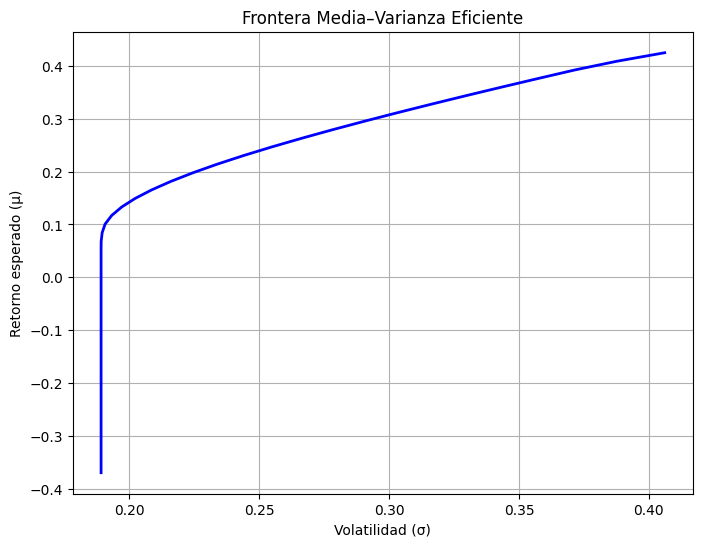

In [15]:
import matplotlib.pyplot as plt

mus, risks, weights = efficient_frontier(mu, Sigma)

plt.figure(figsize=(8,6))
plt.plot(risks, mus, "b-", linewidth=2)
plt.xlabel("Volatilidad (σ)")
plt.ylabel("Retorno esperado (µ)")
plt.title("Frontera Media–Varianza Eficiente")
plt.grid(True)
plt.show()
